In [1]:
from tensorflow import keras

from keras.utils.np_utils import to_categorical
from keras import models
from keras import layers
from keras.layers import BatchNormalization
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers

from keras.models import load_model
from keras import regularizers
from keras.models import Sequential


from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, MaxAbsScaler

from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc, SCORERS
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

from sklearn import set_config
set_config(display ="diagram")

import warnings
#warnings.filterwarnings(action='ignore', category=UserWarning)
#warnings.filterwarnings(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import librosa
from librosa import cqt
from librosa.feature import *

from datetime import datetime
#import sox
#import ffmpeg
import os
#import shutil

#sox.file_info.file_extension('mono/Whispering - 0.wav')
#source_path='stereo'
#tfm = sox.Transformer()

import matplotlib.pyplot as plt
import librosa.display
%matplotlib inline


In [2]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()



In [3]:
# music_dir='data/music2'

# for base,(dirpath, dirnames, filenames) in enumerate(os.walk(music_dir)):
#     if base == 0:
#         genres=dirnames

# #genres.pop(genres.index('Soul'))
        
# genres

In [5]:

df=pd.read_csv('data/features2/features_selected_6sec_14genres.csv')
df.shape


(22945, 35)

In [6]:
#df=df[df['genre']!='Soul']



In [7]:

X = df.drop(['genre','file_name','mfcc_19','mfcc_18','mfcc_17','mfcc_16','mfcc_15','mfcc_14', 'mfcc_13'],axis=1)

y=df['genre']

X.columns


Index(['rms_mean', 'chroma_stft_mean', 'spectral_centroid_mean',
       'spectral_bandwidth_mean', 'spectral_rolloff_mean',
       'zero_crossing_rate_mean', 'mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3',
       'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
       'mfcc_11', 'mfcc_12', 'spectral_contrast_0', 'spectral_contrast_1',
       'spectral_contrast_2', 'spectral_contrast_3', 'spectral_contrast_4',
       'spectral_contrast_5', 'spectral_contrast_6'],
      dtype='object')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

encoder = LabelEncoder()
y_test_num = encoder.fit_transform(y_test)
y_train_num = encoder.fit_transform(y_train)

In [16]:
XGB_pipeline = Pipeline([( "scaler", StandardScaler() ),
                  ('boost', XGBClassifier(use_label_encoder=False, 
                                          eval_metric='auc', gamma= 0.0125, max_depth=7, n_estimators=300, n_jobs=-1))
                 ])

In [17]:

#pipe_grid={'boost__max_depth':[5,6,7], 'boost__n_estimators':[100], 'boost__gamma':[0.1]}
pipe_grid={}
gs_pipe = GridSearchCV(estimator=XGB_pipeline, param_grid=pipe_grid,  cv=3, scoring='accuracy', verbose=2)



In [18]:
gs_pipe.fit(X_train, y_train_num)




Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .................................................... total time= 1.7min
[CV] END .................................................... total time= 1.6min
[CV] END .................................................... total time= 1.5min


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('boost',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      eval_metric='auc',
                                                      gamma=0.0125, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=7,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=300,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None,
                                                      reg_alpha=None,
                                                      reg_lambda=None,
                                                      scale_pos_weight=None,
                                                      subsample=None,
                                                      tree_method=None,
                                                      use_label_encoder=False,
                                                      validate_parameters=None,
                                                      verbosity=None))]),
             param_grid={}, scoring='accuracy', verbose=2)

In [19]:
gs_pipe.best_params_

{}

In [20]:
y_pred_train=gs_pipe.predict(X_train)
y_pred_test=gs_pipe.predict(X_test)

In [22]:
print(gs_pipe.score(X_test, y_test ))
print(classification_report(y_train_num, y_pred_train))
print('------------')
print(classification_report(y_test_num, y_pred_test))

0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1298
           1       1.00      1.00      1.00      1648
           2       1.00      1.00      1.00      1448
           3       1.00      1.00      1.00      1412
           4       1.00      1.00      1.00       823
           5       1.00      1.00      1.00      1466
           6       1.00      1.00      1.00      1482
           7       1.00      1.00      1.00      1081
           8       1.00      1.00      1.00      1228
           9       1.00      1.00      1.00       920
          10       1.00      1.00      1.00      1496
          11       1.00      1.00      1.00      1139
          12       1.00      1.00      1.00      1545
          13       1.00      1.00      1.00      1370

    accuracy                           1.00     18356
   macro avg       1.00      1.00      1.00     18356
weighted avg       1.00      1.00      1.00     18356

------------
        

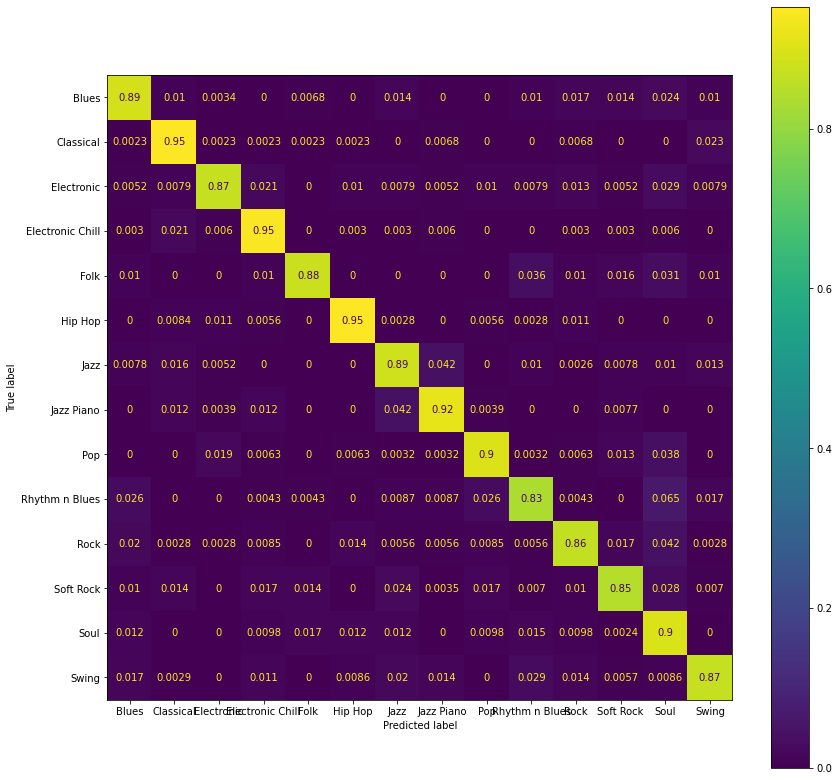

In [25]:
fig, ax = plt.subplots(figsize=(14,14))
ConfusionMatrixDisplay.from_predictions(y_test_num, y_pred_test, display_labels=encoder.classes_, ax=ax, normalize='true');

In [24]:
import joblib
with open('models3/XGB_6sec_14genres.joblib', 'wb') as f:
    joblib.dump(gs_pipe, f)

    

<BarContainer object of 26 artists>

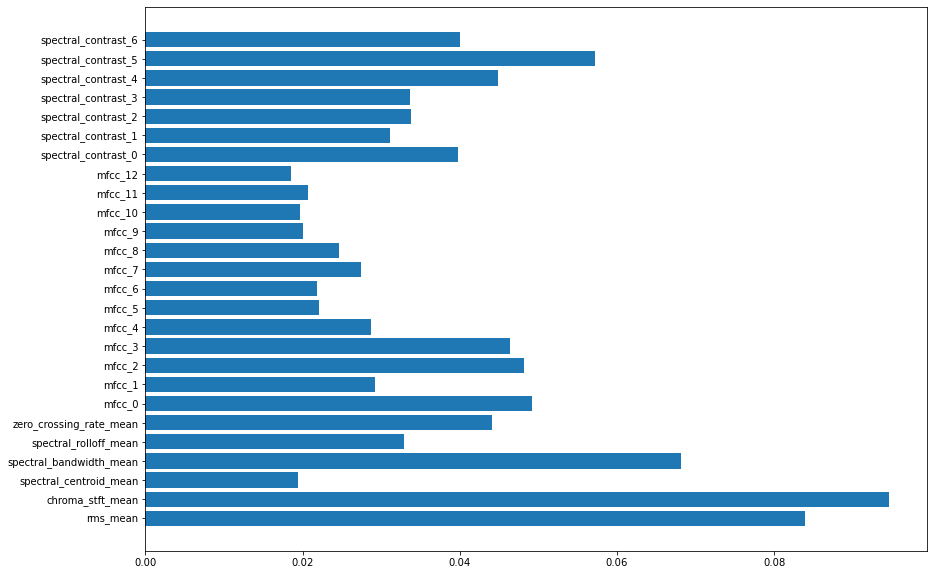

In [31]:
fig, ax = plt.subplots(figsize=(14,10))
ax.barh(gs_pipe.feature_names_in_, gs_pipe.best_estimator_[1].feature_importances_)


Index(['rms_mean', 'chroma_stft_mean', 'spectral_centroid_mean',
       'spectral_bandwidth_mean', 'spectral_rolloff_mean',
       'zero_crossing_rate_mean', 'mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3',
       'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
       'mfcc_11', 'mfcc_12', 'spectral_contrast_0', 'spectral_contrast_1',
       'spectral_contrast_2', 'spectral_contrast_3', 'spectral_contrast_4',
       'spectral_contrast_5', 'spectral_contrast_6'],
      dtype='object')

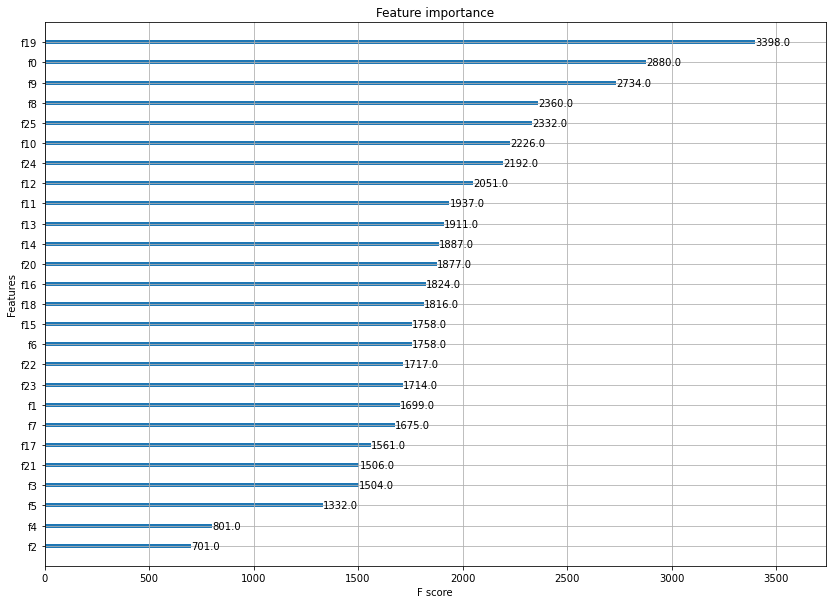

In [43]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(14,10))
plot_importance( gs_pipe.best_estimator_[1], ax=ax);

X_train.columns